In [1]:
import contextlib
import joblib
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.metrics import roc_curve
from tqdm.notebook import trange, tqdm

from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest

In [2]:
# @contextlib.contextmanager
# def tqdm_joblib(tqdm_object):
#     """Context manager to patch joblib to report into tqdm progress bar given as argument"""
#     class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
#         def __call__(self, *args, **kwargs):
#             tqdm_object.update(n=self.batch_size)
#             return super().__call__(*args, **kwargs)

#     old_batch_callback = joblib.parallel.BatchCompletionCallBack
#     joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
#     try:
#         yield tqdm_object
#     finally:
#         joblib.parallel.BatchCompletionCallBack = old_batch_callback
#         tqdm_object.close()

In [3]:
FILE = "mendseq.featurematrix.csv.pkl"

N_ESTIMATORS = list(range(100, 4001, 100))
# N_ESTIMATORS[0] = 10
REPS = 5

In [4]:
def sensitivity_at_specificity(y_true, y_score, target_specificity=0.98, pos_label=1):
    n_trees, n_samples, n_classes = y_score.shape

    # Compute nan-averaged y_score along the trees axis
    y_score_avg = np.nanmean(y_score, axis=0)

    # Extract true labels and nan-averaged predicted scores for the positive class
    y_true = y_true.ravel()
    y_score_binary = y_score_avg[:, 1]

    # Identify rows with NaN values in y_score_binary
    nan_rows = np.isnan(y_score_binary)

    # Remove NaN rows from y_score_binary and y_true
    y_score_binary = y_score_binary[~nan_rows]
    y_true = y_true[~nan_rows]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score_binary, pos_label=pos_label)

    # Find the threshold corresponding to the target specificity
    index = np.argmax(fpr >= (1 - target_specificity))
    threshold_at_specificity = thresholds[index]

    # Compute sensitivity at the chosen specificity
    # sensitivity = tpr[index]
    # return sensitivity

    # Use the threshold to classify predictions
    y_pred_at_specificity = (y_score_binary >= threshold_at_specificity).astype(int)

    # Compute sensitivity at the chosen specificity
    sensitivity = np.sum((y_pred_at_specificity == 1) & (y_true == 1)) / np.sum(
        y_true == 1
    )

    return sensitivity

In [5]:
data = np.load(FILE, allow_pickle=True)
columns_to_remove = [
    "Run",
    "Sample",
    "Library",
    "Cancer Status",
    "Tumor type",
    "MAF",
    "Stage",
    "P7",
    "P7 primer",
    "P7 Primer",
    "Library volume",
    "Library Volume",
    "UIDs Used",
    "Avg GC",
    "Library volume (uL)",
    "Total Reads",
    "Total Alu",
]
y = data["Cancer Status"].to_numpy()
features = data.loc[:, ~data.columns.isin(columns_to_remove)].columns.tolist()
X = data.loc[:, features].to_numpy()
X = np.nan_to_num(X)
X.shape, y.shape

((1992, 1024), (1992,))

In [6]:
# total_sas98s = []
# for n_estimators in tqdm(N_ESTIMATORS, desc="Estimators"):
#     sas98s = []
#     for reps in trange(REPS, desc="REPS"):
#         est = HonestForestClassifier(
#             n_estimators=n_estimators,
#             # random_state=seed,
#             honest_fraction=0.5,
#             n_jobs=-1,
#             bootstrap=True,
#             stratify=True,
#             max_samples=1.6,
#             # permute_per_tree=True,
#         )
        
#         _, posterior_arr = build_hyppo_oob_forest(
#             est,
#             X,
#             y,
#             verbose=False,
#         )
#         sas98 = sensitivity_at_specificity(
#             y, posterior_arr, target_specificity=0.98
#         )
#         sas98s.append(sas98)
#     total_sas98s.append(sas98s)

In [7]:
# np.array(total_sas98s)

In [8]:
# fig, ax = plt.subplots()
# ax.plot(N_ESTIMATORS, np.var(total_sas98s, axis=1))
# ax.set(
#     xlabel="Number of Trees",
#     ylabel="Variance of S@98 Statistic",
#     title="Variance of S@98 Stat vs. Number of Trees"
# )
# plt.show()

In [9]:
# fig, ax = plt.subplots()
# ax.plot(N_ESTIMATORS, np.mean(total_sas98s, axis=1))
# ax.set(
#     xlabel="Number of Trees",
#     ylabel="Mean of S@98 Statistic",
#     title="Mean of S@98 Stat vs. Number of Trees"
# )
# plt.show()

In [10]:
# total_sas98s = []
# for seed in trange(10, desc="Reps S@98"):
#     est = HonestForestClassifier(
#         n_estimators=N_ESTIMATORS[-1],
#         random_state=seed,
#         honest_fraction=0.5,
#         n_jobs=-1,
#         bootstrap=True,
#         stratify=True,
#         max_samples=1.6,
#         # permute_per_tree=True,
#     )
#     _, posterior_arr = build_hyppo_oob_forest(
#         est,
#         X,
#         y,
#         verbose=False
#     )

#     sas98s = []
#     for tree in N_ESTIMATORS:
#         sas98 = sensitivity_at_specificity(
#             y, posterior_arr[:tree, :, :], target_specificity=0.98
#         )
#         sas98s.append(sas98)
#     total_sas98s.append(sas98s)

In [11]:
# fig, ax = plt.subplots()
# ax.plot(N_ESTIMATORS, np.var(total_sas98s, axis=0))
# ax.set(
#     xlabel="Number of Trees",
#     ylabel="Variance of S@98 Statistic",
#     title="Variance of S@98 Stat vs. Number of Trees"
# )
# plt.show()

In [12]:
# fig, ax = plt.subplots()
# ax.plot(N_ESTIMATORS, sas98s)
# ax.set(
#     xlabel="Number of Trees",
#     ylabel="Variance of S@98 Statistic",
#     title="Variance of S@98 Stat vs. Number of Trees"
# )
# plt.show()

In [14]:
sas98s = []
for seed in trange(100, desc="Reps Histogram S@98"):
    est = HonestForestClassifier(
        n_estimators=1600,
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=-1,
        bootstrap=True,
        stratify=True,
        max_samples=1.6,
        # permute_per_tree=True,
    )
    _, posterior_arr = build_hyppo_oob_forest(
        est,
        X,
        y,
        verbose=False
    )
    sas98 = sensitivity_at_specificity(
        y, posterior_arr, target_specificity=0.98
    )
    sas98s.append(sas98)

Reps Histogram S@98:   0%|          | 0/100 [00:00<?, ?it/s]

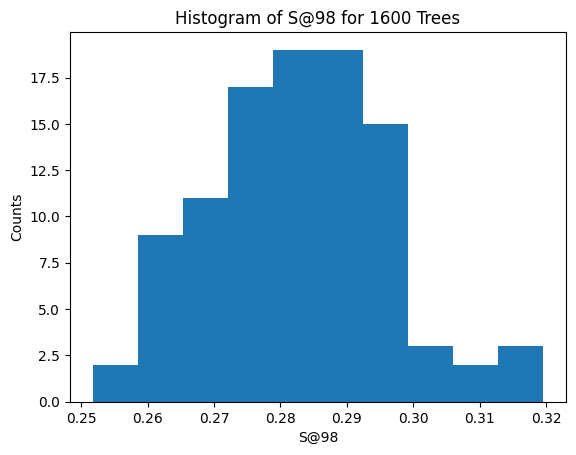

In [16]:
fig, ax = plt.subplots()
ax.hist(sas98s)
ax.set(
    xlabel="S@98",
    ylabel="Counts",
    title="Histogram of S@98 for 1600 Trees"
)
plt.show()

In [17]:
sas98s = []
for seed in trange(100, desc="Reps Histogram S@98"):
    est = HonestForestClassifier(
        n_estimators=4000,
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=-1,
        bootstrap=True,
        stratify=True,
        max_samples=1.6,
        # permute_per_tree=True,
    )
    _, posterior_arr = build_hyppo_oob_forest(
        est,
        X,
        y,
        verbose=False
    )
    sas98 = sensitivity_at_specificity(
        y, posterior_arr, target_specificity=0.98
    )
    sas98s.append(sas98)

Reps Histogram S@98:   0%|          | 0/100 [00:00<?, ?it/s]

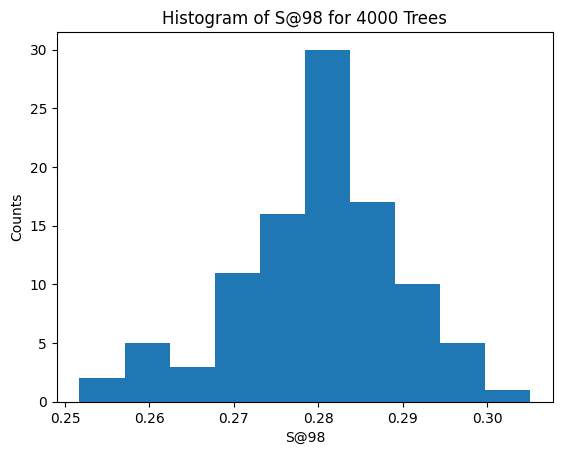

In [19]:
fig, ax = plt.subplots()
ax.hist(sas98s)
ax.set(
    xlabel="S@98",
    ylabel="Counts",
    title="Histogram of S@98 for 4000 Trees"
)
plt.show()